In [24]:
%cd ~/desktop/RNA/casp16
!source ~/.bash_profile

/Users/sumishunsuke/Desktop/RNA/casp16


# R1209のenergy計算

In [25]:
ls ./datasets/casp16/R1209/pdb/*pdb | wc -l

    1000


In [26]:
!echo $PATH | grep BRiQ


/Users/sumishunsuke/micromamba/envs/casp16/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/sumishunsuke/micromamba/envs/casp16/bin:/Users/sumishunsuke/opt/miniconda3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/TeX/texbin:/Users/sumishunsuke/Desktop/RNA/agobec/reditools2.0/src/cineca:/Users/sumishunsuke/opt/miniconda3/envs/r2r/bin:/Users/sumishunsuke/desktop/RNA/plmc/bin:/Users/sumishunsuke/desktop/RNA/rosetta.source.release-362/main/source/bin:/Users/sumishunsuke/desktop/RNA/motifex/RNA-BRiQ/build/bin:/Users/sumishunsuke/desktop/RNA/casp16/third_party/RNA-BRiQ/build/bin:/Users/sumishunsuke/desktop/RNA/RNAmake/rnamake/lib/RNAMake/cmake/build:/Users/sumishunsuke/desktop/RNA/RNAmake/rnamake/bin:/Users/sumishunsuke/deskto

In [27]:
pdb_dir="./datasets/casp16/R1209/pdb"
!python ./scripts/eval_scores.py --pdb_dir {pdb_dir} --out_dir {pdb_dir}

^C
Traceback (most recent call last):
  File "/Users/sumishunsuke/Desktop/RNA/casp16/./scripts/eval_scores.py", line 8, in <module>
    import pandas as pd
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/pandas/__init__.py", line 14, in <module>
    __import__(_dependency)
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/numpy/__init__.py", line 159, in <module>
    from . import ma
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/numpy/ma/__init__.py", line 42, in <module>
    from . import core
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/site-packages/numpy/ma/core.py", line 24, in <module>
    import inspect
  File "/Users/sumishunsuke/micromamba/envs/casp16/lib/python3.12/inspect.py", line 1725, in <module>
    _FrameInfo = namedtuple('_FrameInfo', ('frame',) + Traceback._fields)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/

In [ ]:
briq_out_files = !ls {pdb_dir}/*out


energies = {}
for f in briq_out_files:
    with open(f) as fh: lines = fh.readlines()
    energies[f] = float(lines[-1].strip().replace("Energy: ", ""))

In [ ]:
energies["./datasets/casp16/R1209/pdb/S_000001.briq.out"]

-112.322

(394, 3)


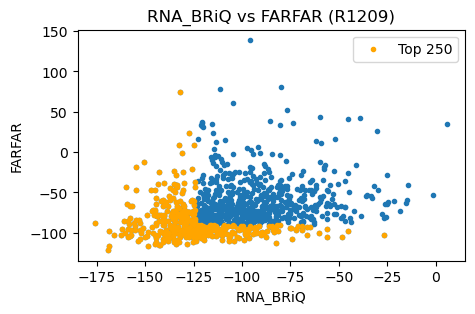

In [66]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df_briq = pd.read_table(os.path.join(pdb_dir, "energies_RNABRiQ.txt"), sep=" ")
df_briq["pdb"] = df_briq["pdb"].apply(lambda x: x.split("/")[-1].replace(".pdb", ""))
df_briq.columns = ["pdb", "RNA_BRiQ"]
df_farfar = pd.read_csv(os.path.join(pdb_dir, "R1209_FARFAR2_scores.csv"))
df_farfar = df_farfar[["description", "score"]]
df_farfar.columns = ["pdb", "FARFAR"]

df = pd.merge(df_briq, df_farfar, on="pdb")

# take top100 from both scores
n_take = 250
df_briq_top = df.sort_values("RNA_BRiQ", ascending=True).head(n_take)
df_farfar_top = df.sort_values("FARFAR", ascending=True).head(n_take)
df_both_top = pd.concat([df_briq_top, df_farfar_top]).drop_duplicates()


plt.figure(figsize=(5,3))
plt.scatter(df["RNA_BRiQ"], df["FARFAR"], marker=".")
plt.scatter(df_both_top["RNA_BRiQ"], df_both_top["FARFAR"], marker=".", color="orange", label=f"Top {n_take}")
plt.legend()
plt.xlabel("RNA_BRiQ")
plt.ylabel("FARFAR")
plt.title("RNA_BRiQ vs FARFAR (R1209)")

print(df_both_top.shape)

In [62]:
# write pdb list to file
# df_both_top.to_csv(os.path.join(pdb_dir, f"top{n_take}_RNA_BRiQ_FARFAR.csv"), index=False)

In [67]:
df_both_top


,pdb,RNA_BRiQ,FARFAR
571,S_000777,-175.7360,-87.593
537,S_000158,-168.8970,-121.639
723,S_000203,-168.5830,-97.862
450,S_000220,-168.5090,-117.063
204,S_000651,-166.2150,-103.058
...,...,...,...
845,S_000299,-82.1214,-90.741
882,S_000887,-104.6220,-90.467
784,S_000265,-122.5570,-90.419
311,S_000742,-121.3250,-90.373


In [71]:
# cp selected pdb to new dir    
!mkdir -p ./datasets/casp16/R1209/pdb_selected
for pdb in df_both_top["pdb"]:
    !cp {pdb_dir}/{pdb}.pdb ./datasets/casp16/R1209/pdb_selected

# R1209の距離計算, MDS

In [68]:
pdb_dir="./datasets/casp16/R1209/pdb"
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser, Superimposer
from sklearn.manifold import MDS
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [91]:
%cd ~/desktop/RNA/casp16
!time python scripts/calc_rmsd.py --pdb_dir datasets/casp16/R1209/pdb --cpu 8

/Users/sumishunsuke/Desktop/RNA/casp16
['S_000001.pdb', 'S_000002.pdb', 'S_000003.pdb', 'S_000004.pdb', 'S_000005.pdb']
Number of pdb files: 1000
Calculating RMSD matrix 1000x1000 using 8 cpus
Calculating RMSD for 0th pdb file
Calculating RMSD for 100th pdb file
Calculating RMSD for 50th pdb file


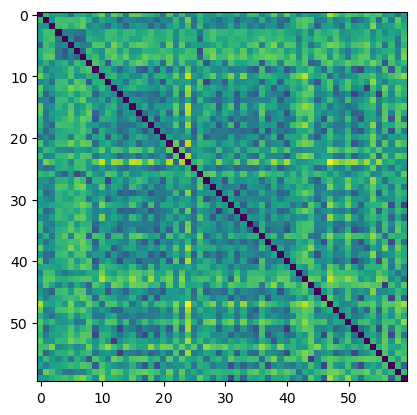

In [88]:
import matplotlib.pyplot as plt
import numpy as np

arr = np.load("./datasets/casp16/R1209/pdb/rmsd_matrix_sorted_id.npy")
plt.imshow(arr, cmap="viridis")